### Problem Statement

#### Objectives
A leading agri-tech company, AgroTech Innovations, faces significant challenges in optimising crop yields
and resource management due to inefficiencies in their controlled environment farming systems.
Despite having advanced sensor technologies, the company seeks to enhance its operational efficiency
and support future research and development initiatives.  

As a machine learning engineer at AgroTech Innovations, you are tasked with developing machine
learning models to address these challenges. Your goal is to create models to predict the temperature
conditions within the farm's closed environment, ensuring optimal plant growth. Additionally, you will
develop models to categorise the combined "Plant Type-Stage" based on sensor data, aiding in
strategic planning and resource allocation.  

By implementing these models, you will help AgroTech Innovations improve crop management,
optimise resource usage, and increase yield predictability. These efforts will not only enhance current
operations but also provide valuable insights for future agricultural innovations.  

In your submission, you are expected to evaluate at least two suitable models for each task and justify
your choices based on the dataset provided.

#### Dataset
The dataset contains sensor readings and plant-related information collected from various agricultural
zones within a controlled environment. It includes features such as temperature, humidity, light intensity,
CO2 levels, and nutrient concentrations. Note that the dataset may contain synthetic data. Therefore, you
would need to state any assumptions you make.  
    
You can query the datasets using the following URL:  
https://techassessment.blob.core.windows.net/aiap19-assessment-data/agri.db

### Libraries / Dependencies

In [1]:
# Import Libraries / Dependencies
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

# # Analysis and Transformers
# from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
# #from collections import defaultdict
# from sklearn.preprocessing import OneHotEncoder,  StandardScaler , MinMaxScaler , LabelEncoder
# #from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import mutual_info_classif # ,mutual_info_regression
# from sklearn.impute import KNNImputer

### Data Ingestion

In [2]:
# Import Raw Data
# Connect to DB
conn = sqlite3.connect('data/agri.db')
# Get list of all tables
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(table_query, conn)
# Load all tables into a dictionary of dataframes
dataframes = {}
for table_name in tables['name']:
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    dataframes[table_name] = df
    print(f"Loaded table: {table_name}, shape: {df.shape}")

Loaded table: farm_data, shape: (57489, 15)


In [3]:
# Querying the table
query = f"SELECT * FROM farm_data"
df_raw = pd.read_sql_query(query, conn)
conn.close() # Good Practice to close
df_raw.head(10)

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000
5,Zone_C,Vine Crops,FRUITING VEGETABLES,MATURITY,25.96,NaN,675.0,1338,1.75,8,227,53,258,6.2,23.092135
6,Zone_A,Leafy Greens,Vine Crops,Maturity,NaN,NaN,514.0,1103,1.14,8,174,62,217,5.5,35.000000
7,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
8,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
9,Zone_B,Vine Crops,Vine Crops,MATURITY,25.59,NaN,435.0,845,2.07,8,150,70,210,5.3,27.835062


In [4]:
# it is good practice to leave raw data untouched, so make a copy for analysis and revision
df_data = df_raw.copy()

In [5]:
# Basic cleaning of strings
for col in df_data.select_dtypes(include=['object', 'string']):
        df_data[col] = (
            df_data[col]
            .str.lower()                            # Converts text to lowercase
            .str.strip()                            # Strip leading/trailing whitespace
            .str.replace(r'\s+', '', regex=True)    # Remove all whitespace (including between words)
            .str.replace('_', '', regex=False)      # Remove all underscores
            .str.replace('.', '', regex=False)      # Remove all periods
        )

In [6]:
# Quick examination of the data
df_data.nunique()

System Location Code                7
Previous Cycle Plant Type           4
Plant Type                          4
Plant Stage                         3
Temperature Sensor (°C)          1439
Humidity Sensor (%)              2094
Light Intensity Sensor (lux)     1228
CO2 Sensor (ppm)                  702
EC Sensor (dS/m)                  336
O2 Sensor (ppm)                     9
Nutrient N Sensor (ppm)           322
Nutrient P Sensor (ppm)           118
Nutrient K Sensor (ppm)           395
pH Sensor                          39
Water Level Sensor (mm)         10832
dtype: int64

In [7]:
# Quick examination of null values and dtypes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

In [8]:
# Quick Check of duplicates
df_data[df_data.duplicated(keep=False)]

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
7,zoneg,herbs,leafygreens,maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
8,zoneg,herbs,leafygreens,maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
14,zoneb,herbs,fruitingvegetables,maturity,24.50,NaN,664.0,1438,2.22,7,238,72,251,6.3,22.530938
15,zoneb,herbs,fruitingvegetables,maturity,24.50,NaN,664.0,1438,2.22,7,238,72,251,6.3,22.530938
28,zonec,leafygreens,leafygreens,vegetative,21.88,65.62,387.0,1007,0.86,5,115,32,None,6.3,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57468,zonea,leafygreens,leafygreens,vegetative,19.70,68.16,NaN,1198,1.75,5,179,None,261,6.2,20.000000
57476,zonea,fruitingvegetables,fruitingvegetables,vegetative,22.82,NaN,772.0,1258,0.75,7,213,74,213,5.8,25.124531
57477,zonea,fruitingvegetables,fruitingvegetables,vegetative,22.82,NaN,772.0,1258,0.75,7,213,74,213,5.8,25.124531
57484,zonec,vinecrops,fruitingvegetables,maturity,NaN,NaN,619.0,1074,1.95,6,150,61,210,6.4,NaN


### Data Cleaning

In [9]:
# Removing Zone from `System Location Code`
df_data['System Location Code'] = df_data['System Location Code'].str[4:]

In [10]:
# Removing non numeric values from nutrient sensors, converting to int
for col in ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)']:
    df_data[col] = (
        df_data[col]
        .astype(str)                                  # ensure string
        .str.extract(r'(\d+)')                        # keep only digits
        .replace(['none', 'nan', 'null', ''], np.nan) # unify nulls
        .astype('Int64')                              # nullable int dtype
    )


In [11]:
# Pythonic Sankey
def sankey_from_df(df, cols, top_n_per_col=None, dropna=True, title="Sankey"):
    """
    df: DataFrame with categorical columns in flow order
    cols: list[str] of columns in left→right order
    top_n_per_col: int or dict[col->int] to keep only top-N frequent categories per column (others→"Other")
    dropna: if True, drop rows with NA in any col; else fillna("NA")
    """
    data = df.copy()

    # Handle NA
    if dropna:
        data = data.dropna(subset=cols)
    else:
        data[cols] = data[cols].fillna("NA")

    # Optional: collapse long tails to "Other" per column
    if top_n_per_col is not None:
        if isinstance(top_n_per_col, int):
            top_map = {c: top_n_per_col for c in cols}
        else:
            top_map = top_n_per_col
        for c in cols:
            if c in top_map:
                top_vals = data[c].value_counts().nlargest(top_map[c]).index
                data[c] = np.where(data[c].isin(top_vals), data[c], "Other")

    # Build nodes (unique labels across all columns)
    all_labels = pd.unique(pd.concat([data[c].astype(str) for c in cols], ignore_index=True))
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}

    # Build links between consecutive columns
    links = []
    for i in range(len(cols) - 1):
        pair_counts = (
            data.groupby([cols[i], cols[i+1]])
                .size()
                .reset_index(name="value")
        )
        pair_counts["source"] = pair_counts[cols[i]].map(label_to_id)
        pair_counts["target"] = pair_counts[cols[i+1]].map(label_to_id)
        links.append(pair_counts[["source", "target", "value"]])

    links_df = pd.concat(links, ignore_index=True)

    # Plotly Sankey
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            label=list(all_labels),
            pad=15,
            thickness=18,
            line=dict(width=0.5),
        ),
        link=dict(
            source=links_df["source"],
            target=links_df["target"],
            value=links_df["value"],
        )
    )])
    fig.update_layout(title_text=title, font_size=12, height=600)
    return fig


In [12]:
cols = ["Plant Type", "Plant Stage"]  # ← your columns in order
fig = sankey_from_df(df_data, cols, top_n_per_col=8, dropna=True, title="Plant Flow")
fig.show()


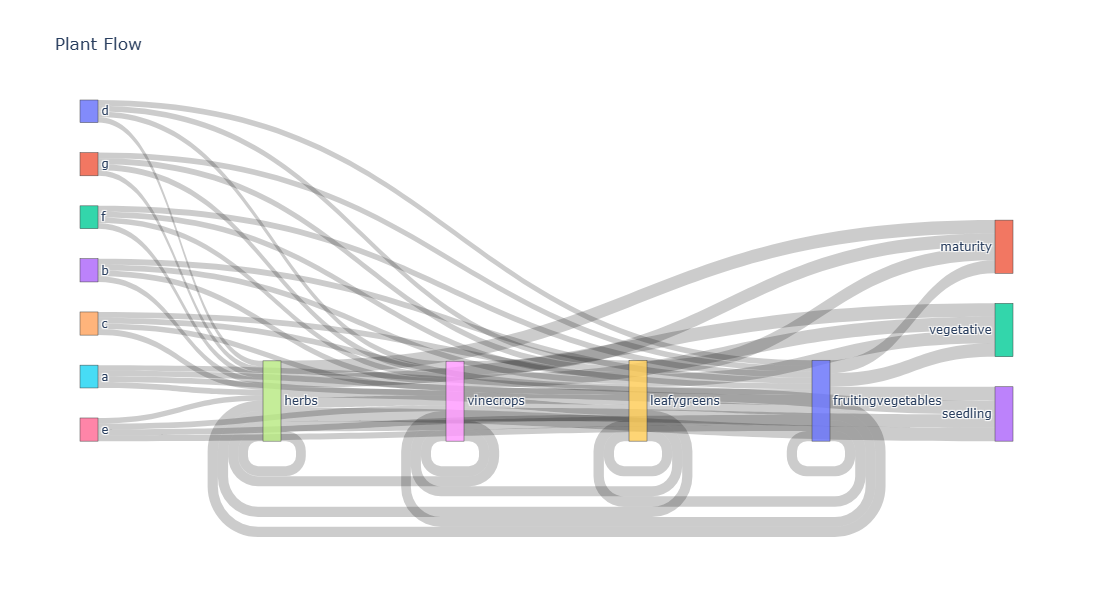

In [16]:
cols = ["System Location Code", "Previous Cycle Plant Type", "Plant Type", "Plant Stage", ]  # ← your columns in order
fig = sankey_from_df(df_data, cols, top_n_per_col=8, dropna=True, title="Plant Flow")
fig.show()

In [14]:
### Alluvial
%load_ext rpy2.ipython

Note: you may need to restart the kernel to use updated packages.
